### Importing Libraries

In [2]:
import pandas as pd
import nltk
import re
from sklearn import *
import time
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from nltk.metrics.distance  import edit_distance
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Spelling Correction Strategy! (Will Try Later)

In [3]:
# nltk.download('words')
# from nltk.corpus import words
# correct_words = words.words()

In [4]:
# incorrect_words=['happpy', 'azmaing', 'intelliengt']
# for word in incorrect_words:
#     temp = [(edit_distance(word, w),w) for w in correct_words if w[0]==word[0]]
#     print(sorted(temp, key = lambda val:val[0])[0][1])

### Function for Data Cleaning

In [5]:
def dataClean(tweets_raw):
    cleanTweets = []
    for tweet in tweets_raw:
        tweet = tweet.lower() #convert to lowercase
        tweet = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet) #remove URL
        tweet = re.sub(r'(\s)@\w+', r'', tweet) #remove usernames
        tweet = re.sub(r'@\w+', r'', tweet) #remove usernames
        tweet = re.sub('<[^<]+?>', '', tweet) #remove HTML tags
        # tweet = re.sub(r'[<>!#@$:.,%\?-]+', r'', tweet) #remove punctuation and special characters
        tweet = re.sub('[^A-Za-z0-9 ]+', '', tweet)
        tweet = re.sub(" \d+", " ", tweet) #remove standalone numbers
        lower_case = tweet.lower() #tokenization
        
        words = lower_case.split()
        tweet = ' '.join([w for w in words if not w in nltk.corpus.stopwords.words("english")]) #remove stopwords
        ps = nltk.stem.PorterStemmer()
        stemmedTweet = [ps.stem(word) for word in tweet.split(" ")]
        stemmedTweet = " ".join(stemmedTweet)
        tweet = str(stemmedTweet)
        tweet = tweet.replace("'", "")
        tweet = tweet.replace("\"","")
        
#         list_w = []
#         for word in tweet.split():
#             temp = [(edit_distance(word, w),w) for w in correct_words if w[0]==word[0]]
#             print(sorted(temp, key = lambda val:val[0])[0][1])
        
        #print(list_w)
        cleanTweets.append(tweet)
        
    return cleanTweets

### Function to Vectorize Cleaned Data

In [6]:
def vectorization(clean_train_tweets, clean_test_tweets):
    vec = feature_extraction.text.TfidfVectorizer(min_df = 0.00125, max_df = 0.7, sublinear_tf=True, use_idf=True, stop_words=u'english', analyzer= 'word', ngram_range=(1,5),lowercase=True)
    train_vectors = vec.fit_transform(clean_train_tweets)
    test_vectors = vec.transform(clean_test_tweets)
    #print(train_vectors.shape)
    #print(vec.get_feature_names())
    return train_vectors, test_vectors

### Load the Training File 

In [7]:
trainingFile = "training-Obama-Romney-tweets.xlsx"
df_obama = pd.read_excel(trainingFile,sheet_name='Obama')
df_romney = pd.read_excel(trainingFile,sheet_name='Romney')

In [8]:
df_obama.drop(df_obama.columns[0], axis=1, inplace = True)
df_obama.drop(df_obama.columns[4:], axis=1, inplace = True)

df_obama.drop([0],inplace=True)
df_obama.rename(columns={df_obama.columns[3]: 'Class'}, inplace = True)
#df_obama

In [9]:
df_romney.drop(df_romney.columns[0], axis=1, inplace = True)
df_romney.drop(df_romney.columns[4:], axis=1, inplace = True)

df_romney.drop([0],inplace=True)
df_romney.rename(columns={df_romney.columns[3]: 'Class'}, inplace = True)
#df_romney

### Remove Neutral Sentiments (Only Keep Positive & Negative)

In [10]:
df_obama = df_obama[(df_obama['Class'].isin((1,-1)))]
df_romney = df_romney[(df_romney['Class'].isin((1,-1)))]

### Distribution of Class

In [11]:
print(df_obama["Class"].value_counts())
print(df_romney["Class"].value_counts()) #Romney Data Skewed

-1    1922
 1    1653
Name: Class, dtype: int64
-1    2893
 1    1075
Name: Class, dtype: int64


### Data Preprocessing Steps

In [12]:
obama_tweets_raw = df_obama['Anootated tweet']
obama_class = df_obama['Class']
romney_tweets_raw = df_romney['Anootated tweet']
romney_class = df_romney['Class']

In [13]:
# Conversion to List
obama_tweets_raw = obama_tweets_raw.tolist()
romney_tweets_raw = romney_tweets_raw.tolist()

In [14]:
# Conversion to List
obama_class_train = obama_class.tolist()
romney_class_train = romney_class.tolist()

In [15]:
# Data Preprocessing
obama_tweets = dataClean(obama_tweets_raw)
romney_tweets = dataClean(romney_tweets_raw)

In [16]:
#Train-Test Split
obama_train, obama_test, obama_train_class, obama_test_class = train_test_split(obama_tweets, obama_class_train, test_size=0.2, random_state=42)
romney_train, romney_test, romney_train_class, romney_test_class = train_test_split(romney_tweets, romney_class_train, test_size=0.2, random_state=42)

### Vectorization

In [17]:
# TF-IDF Vectorization
obama_train_corpus, obama_test_corpus = vectorization(obama_train,obama_test)
romney_train_corpus, romney_test_corpus = vectorization(romney_train,romney_test)
#romney_train_corpus

### Oversampling Romney Data to Handle Class Imbalance

In [18]:
# Oversampling Romney Data to Handle Class Imbalance
# sm = SMOTE(n_jobs=3)
# romney_train_corpus, romney_train_class = sm.fit_resample(romney_train_corpus, romney_train_class)
# print ("End Over Sampling")

### ML Models: Naive Bayes, SVM, Decision Tree, Random Forest, Logistic Regression, SGD, Neural Network

In [19]:
models = [naive_bayes.BernoulliNB(),svm.SVC(kernel='rbf', gamma=1, C=1, class_weight='balanced'),tree.DecisionTreeClassifier(random_state=0,class_weight='balanced'),ensemble.RandomForestClassifier(criterion='entropy', n_jobs = 10,class_weight='balanced'),linear_model.LogisticRegression(class_weight='balanced'),linear_model.SGDClassifier(class_weight='balanced'),neural_network.MLPClassifier()]

### GridSearch for HyperParameter Tuning

In [20]:
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# param_grid = {'C': Cs, 'gamma' : gammas}
# grid_search = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)
# grid_search.fit(obama_train_corpus, obama_train_class)
# grid_search.best_params_

### Performance Analysis: Test Data

In [21]:
#Storing the values to have plot analysis
Obama_Precision_Positive = []
Obama_Precision_Negative = []
Obama_Recall_Positive = []
Obama_Recall_Negative = []
Obama_F1_Score_Positive = []
Obama_F1_Score_Negative = []
Obama_Accuracy = []

Romney_Precision_Positive = []
Romney_Precision_Negative = []
Romney_Recall_Positive = []
Romney_Recall_Negative = []
Romney_F1_Score_Positive = []
Romney_F1_Score_Negative = []
Romney_Accuracy = []

In [51]:
for clf in models:
    #obama
    clf.fit(obama_train_corpus, obama_train_class)
    preds = clf.predict(obama_test_corpus)
    accScore = metrics.accuracy_score(obama_test_class,preds)
    labels = [1,-1]
    precision = metrics.precision_score(obama_test_class,preds,average=None,labels=labels)
    recall = metrics.recall_score(obama_test_class,preds,average=None,labels=labels)
    f1Score = metrics.f1_score(obama_test_class,preds,average=None,labels=labels)
    print(clf);print("Obama: \nOverall Acurracy: ",accScore,"\n")
    Obama_Accuracy.append(accScore)
    lbl = ['positive', 'negative']
    for i in range(2):
        print("Precision of %s class: %f" %(lbl[i],precision[i]))
        print("Recall of %s class: %f" %(lbl[i],recall[i]))
        print("F1-Score of %s class: %f" %(lbl[i],f1Score[i]),"\n")
        if(i==0): 
            Obama_F1_Score_Positive.append(f1Score[i])
            Obama_Precision_Positive.append(precision[i])
            Obama_Recall_Positive.append(recall[i])
        else: 
            Obama_F1_Score_Negative.append(f1Score[i])
            Obama_Precision_Negative.append(precision[i])
            Obama_Recall_Negative.append(recall[i])
    
    #romney
    clf.fit(romney_train_corpus, romney_train_class)
    preds = clf.predict(romney_test_corpus)
    accScore = metrics.accuracy_score(romney_test_class,preds)
    labels = [1,-1]
    precision = metrics.precision_score(romney_test_class,preds,average=None,labels=labels)
    recall = metrics.recall_score(romney_test_class,preds,average=None,labels=labels)
    f1Score = metrics.f1_score(romney_test_class,preds,average=None,labels=labels)
    print(clf);print("Romney: \nOverall Acurracy: ",accScore,"\n")
    Romney_Accuracy.append(accScore)
    lbl = ['positive', 'negative']
    for i in range(2):
        print("Precision of %s class: %f" %(lbl[i],precision[i]))
        print("Recall of %s class: %f" %(lbl[i],recall[i]))
        print("F1-Score of %s class: %f" %(lbl[i],f1Score[i]),"\n")
        if(i==0): 
            Romney_F1_Score_Positive.append(f1Score[i])
            Romney_Precision_Positive.append(precision[i])
            Romney_Recall_Positive.append(recall[i])
        else: 
            Romney_F1_Score_Negative.append(f1Score[i])
            Romney_Precision_Negative.append(precision[i])
            Romney_Recall_Negative.append(recall[i])

### Performance Analysis: 10-Fold Cross Validation

In [50]:
#10-Fold Cross Validation Score

for clf in models:
    #start_time = time.clock()
    
    #obama
    preds = model_selection.cross_val_predict(clf, obama_train_corpus, obama_train_class, cv=10)
    accScore = metrics.accuracy_score(obama_train_class,preds)
    labels = [1,-1]
    precision = metrics.precision_score(obama_train_class,preds,average=None,labels=labels)
    recall = metrics.recall_score(obama_train_class,preds,average=None,labels=labels)
    f1Score = metrics.f1_score(obama_train_class,preds,average=None,labels=labels)
    print(clf);print("Obama: \nOverall Acurracy: ",accScore,"\n")
    lbl = ['positive', 'negative']
    for i in range(2):
        print("Precision of %s class: %f" %(lbl[i],precision[i]))
        print("Recall of %s class: %f" %(lbl[i],recall[i]))
        print("F1-Score of %s class: %f" %(lbl[i],f1Score[i]),"\n")
        
    #romney
    preds = model_selection.cross_val_predict(clf, romney_train_corpus, romney_train_class, cv=10)
    accScore = metrics.accuracy_score(romney_train_class,preds)
    precision = metrics.precision_score(romney_train_class,preds,average=None,labels=labels)
    recall = metrics.recall_score(romney_train_class,preds,average=None,labels=labels)
    f1Score = metrics.f1_score(romney_train_class,preds,average=None,labels=labels)
    print("Romney:\nOverall Acurracy: ",accScore,"\n")
    for i in range(2):
        print("Precision of %s class: %f" %(lbl[i],precision[i]))
        print("Recall of %s class: %f" %(lbl[i],recall[i]))
        print("F1-Score of %s class: %f" %(lbl[i],f1Score[i]),"\n")
    #end_time = time.clock()
    #print("Total time taken: %0.2f seconds \n\n"%(end_time-start_time))

# ***Plotting the Performance of The Algorithms***

# ***Obama***

### Obama: Precision

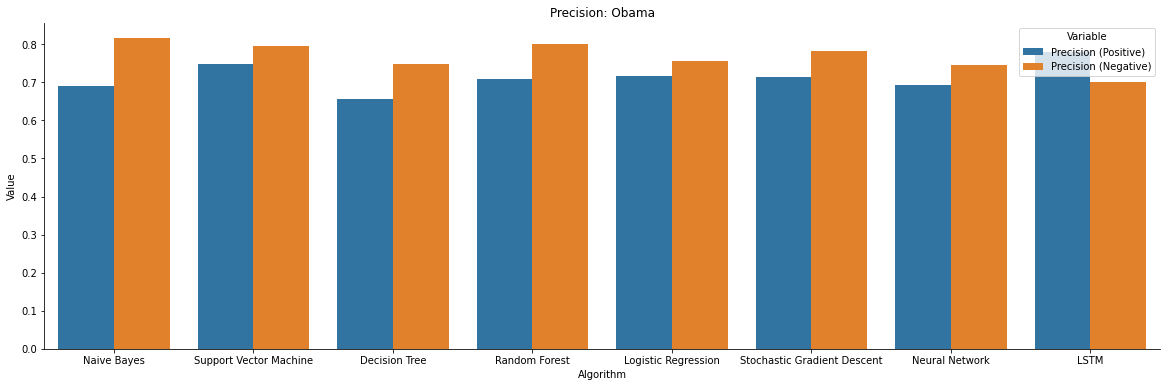

In [24]:
Obama_Precision_Positive.append(0.78) #LSTM
Obama_Precision_Negative.append(0.70) #LSTM

Obama_Precision_df = pd.DataFrame({
    'Algorithm': ['Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Stochastic Gradient Descent', 'Neural Network', 'LSTM'],
    'Precision (Positive)': Obama_Precision_Positive,
    'Precision (Negative)': Obama_Precision_Negative
})
fig, ax1 = plt.subplots(figsize=(20, 6))
tidy = Obama_Precision_df.melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax1).set_title('Precision: Obama')
sns.despine(fig)

### Obama: Recall

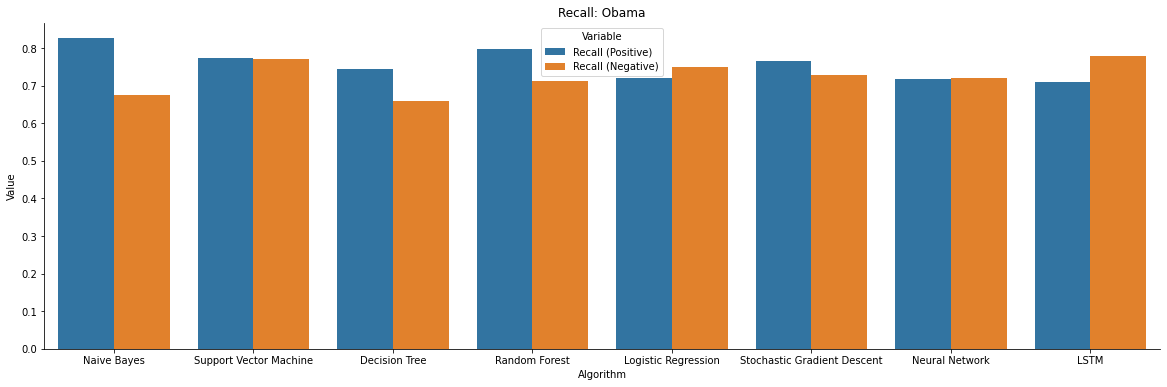

In [25]:
Obama_Recall_Positive.append(0.71) #LSTM
Obama_Recall_Negative.append(0.78) #LSTM

Obama_Recall_df = pd.DataFrame({
    'Algorithm': ['Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Stochastic Gradient Descent', 'Neural Network', 'LSTM'],
    'Recall (Positive)': Obama_Recall_Positive,
    'Recall (Negative)': Obama_Recall_Negative
})
fig, ax1 = plt.subplots(figsize=(20, 6))
tidy = Obama_Recall_df.melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax1).set_title('Recall: Obama')
sns.despine(fig)

### Obama F1-Score

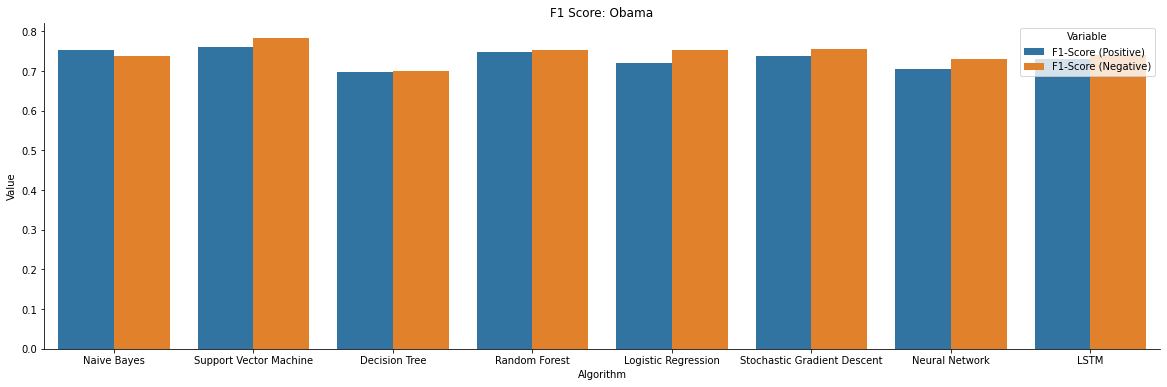

In [26]:
Obama_F1_Score_Positive.append(0.73) #LSTM
Obama_F1_Score_Negative.append(0.74) #LSTM

Obama_F1Score_df = pd.DataFrame({
    'Algorithm': ['Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Stochastic Gradient Descent', 'Neural Network', 'LSTM'],
    'F1-Score (Positive)': Obama_F1_Score_Positive,
    'F1-Score (Negative)': Obama_F1_Score_Negative
})
fig, ax1 = plt.subplots(figsize=(20, 6))
tidy = Obama_F1Score_df.melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax1).set_title('F1 Score: Obama')
sns.despine(fig)

### Obama Accuracy

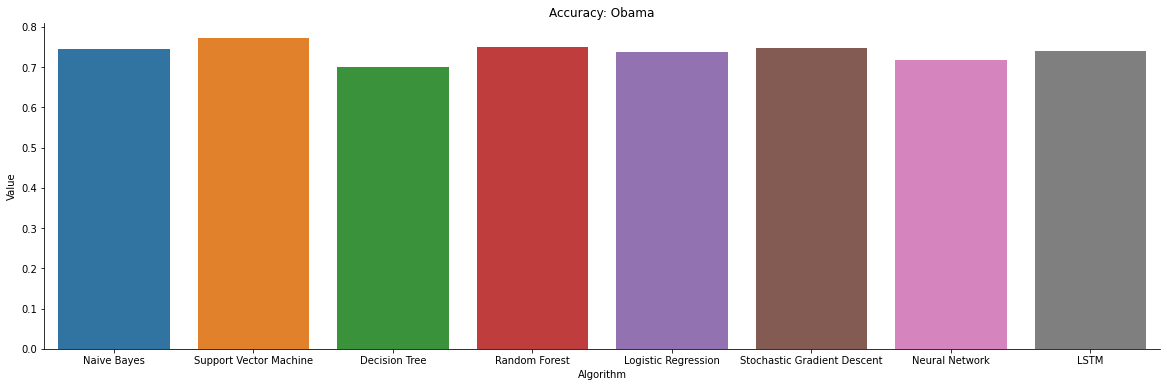

In [27]:
Obama_Accuracy.append(0.74) #LSTM

Obama_Accuracy_df = pd.DataFrame({
    'Algorithm': ['Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Stochastic Gradient Descent', 'Neural Network', 'LSTM'],
    'Accuracy': Obama_Accuracy
})
fig, ax1 = plt.subplots(figsize=(20, 6))
tidy = Obama_Accuracy_df.melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', data=tidy, ax=ax1).set_title('Accuracy: Obama')
sns.despine(fig)

# ***Romney***

### Romney Precision

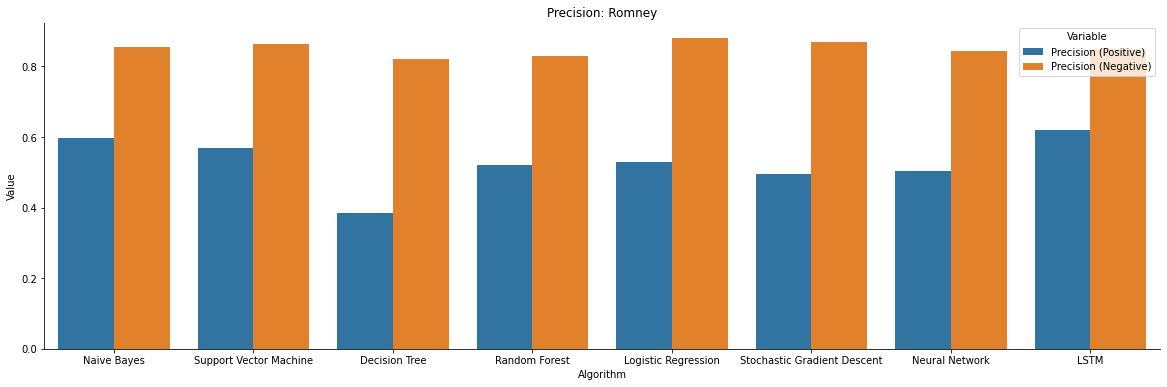

In [49]:
Romney_Precision_Positive.append(0.62) #LSTM
Romney_Precision_Negative.append(0.85) #LSTM

Romney_Precision_df = pd.DataFrame({
    'Algorithm': ['Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Stochastic Gradient Descent', 'Neural Network', 'LSTM'],
    'Precision (Positive)': Romney_Precision_Positive,
    'Precision (Negative)': Romney_Precision_Negative
})
fig, ax1 = plt.subplots(figsize=(20, 6))
tidy = Romney_Precision_df.melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax1).set_title('Precision: Romney')
sns.despine(fig)

### Romney Recall

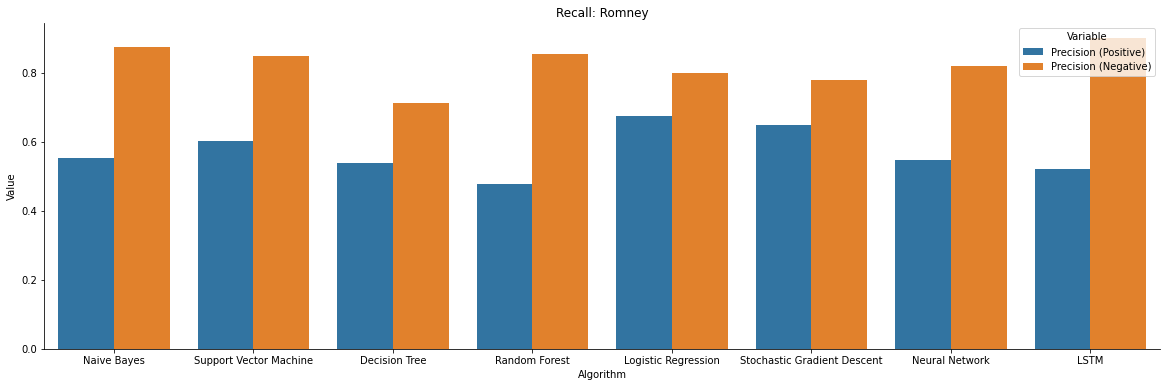

In [29]:
Romney_Recall_Positive.append(0.52) #LSTM
Romney_Recall_Negative.append(0.90) #LSTM

Romney_Recall_df = pd.DataFrame({
    'Algorithm': ['Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Stochastic Gradient Descent', 'Neural Network','LSTM'],
    'Precision (Positive)': Romney_Recall_Positive,
    'Precision (Negative)': Romney_Recall_Negative
})
fig, ax1 = plt.subplots(figsize=(20, 6))
tidy = Romney_Recall_df.melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax1).set_title('Recall: Romney')
sns.despine(fig)

### Romney F1-Score

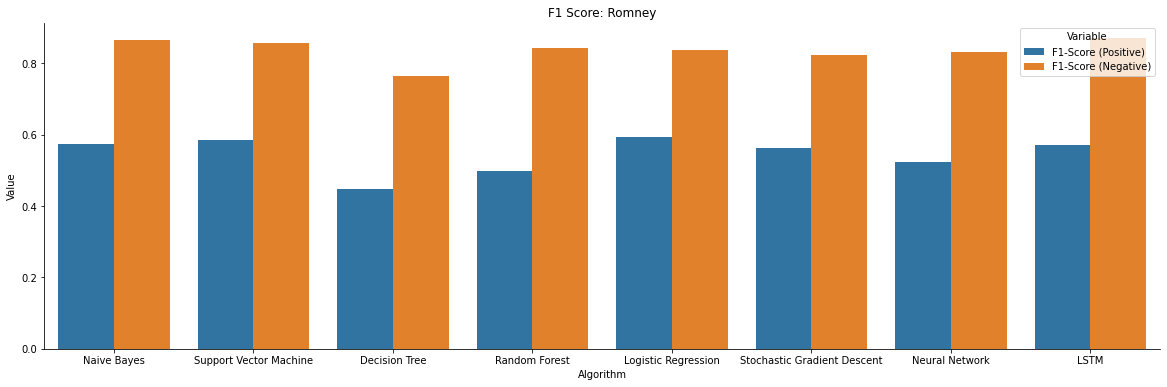

In [30]:
Romney_F1_Score_Positive.append(0.57) #LSTM
Romney_F1_Score_Negative.append(0.87) #LSTM

Romney_F1Score_df = pd.DataFrame({
    'Algorithm': ['Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Stochastic Gradient Descent', 'Neural Network', 'LSTM'],
    'F1-Score (Positive)': Romney_F1_Score_Positive,
    'F1-Score (Negative)': Romney_F1_Score_Negative
})
fig, ax1 = plt.subplots(figsize=(20, 6))
tidy = Romney_F1Score_df.melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax1).set_title('F1 Score: Romney')
sns.despine(fig)

### Romney Accuracy

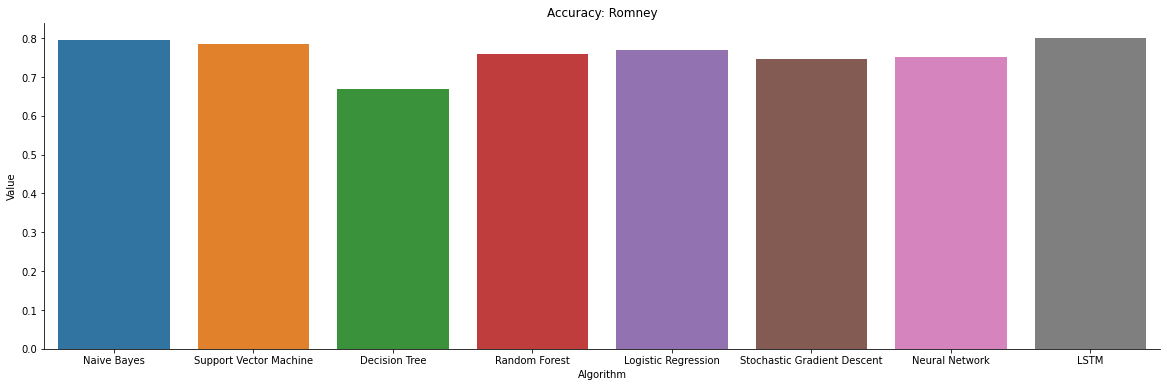

In [31]:
Romney_Accuracy.append(0.80) #LSTM

Romney_Accuracy_df = pd.DataFrame({
    'Algorithm': ['Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Stochastic Gradient Descent', 'Neural Network', 'LSTM'],
    'Accuracy': Romney_Accuracy
})
fig, ax1 = plt.subplots(figsize=(20, 6))
tidy = Romney_Accuracy_df.melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', data=tidy, ax=ax1).set_title('Accuracy: Romney')
sns.despine(fig)

In [32]:
# Romney LSTM

#             Precision  Recall    F1-Score
# Negative       0.85      0.90      0.87
# Positive       0.62      0.52      0.57

# Accuracy       0.80

In [33]:
#Obama LSTM

#             precision    recall  f1-score
# Negative       0.78      0.71      0.74
# Positive       0.70      0.78      0.73

# accuracy       0.74